In [265]:
import numpy as np
import os
import pandas as pd
import sklearn.metrics
import sys

sys.path.append("../src")
import localmodule


args = ["all", "unit01", "trial-0", "unit10"]
aug_kind_str = args[0]
test_unit_str = args[1]
trial_str = args[2]
predict_unit_str = args[3]


data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
folds = localmodule.fold_units()
models_dir = localmodule.get_models_dir()
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join(
        [model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
unit_dir = os.path.join(model_dir, test_unit_str)


plot_x = []
plot_y = []

for trial_id in [0, 1, 2, 3, 4, 6, 7, 8, 9]: # TODO UPDATE ME
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)

    fold = [f for f in folds if test_unit_str in f[0]][0]
    validation_units = fold[2]

    val_df_list = []
    for val_unit_str in validation_units:
        val_pred_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + val_unit_str,
            "clip-predictions.csv"])
        val_pred_path = os.path.join(trial_dir, val_pred_name)
        val_df = pd.read_csv(val_pred_path)
        val_df_list.append(val_df)
    val_df = pd.concat(val_df_list, ignore_index=True)

    val_y_true = list(val_df["Ground truth"])
    val_y_score = list(val_df["Predicted probability"])

    val_fprs, val_tprs, val_thresholds =\
        sklearn.metrics.roc_curve(val_y_true, val_y_score)
     
    # Compute accuracies.
    #     ACC = (TN + TP) / (NEG + POS)
    # The dataset is balanced (NEG = POS) so
    #     ACC = 0.5 * (TN/NEG + TP/POS)
    # We have NEG = FP + TN so
    #     ACC = 0.5 * ((NEG-FP)/NEG + TP/POS)
    # We have FPR = FP/NEG and TPR = TP/POS so
    #     ACC = 0.5 * (1.0 - FPR + TPR)
    val_accuracies = 0.5 * (1.0 - val_fprs + val_tprs)
    cv_best_threshold_id = np.argmax(val_accuracies)
    cv_threshold = val_thresholds[cv_best_threshold_id]
    val_tnr = 1.0 - val_fprs[cv_best_threshold_id]
    val_tpr = val_tprs[cv_best_threshold_id]
    val_acc = val_accuracies[cv_best_threshold_id]
    val_auc = sklearn.metrics.roc_auc_score(
        val_y_true, val_y_score)
    
    
    test_pred_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "clip-predictions.csv"])
    test_pred_path = os.path.join(trial_dir, test_pred_name)
    test_df = pd.read_csv(test_pred_path)

    test_y_true = list(test_df["Ground truth"])
    test_y_score = list(test_df["Predicted probability"])
    
    test_cv_y_pred = np.greater(test_y_score, cv_threshold)
    test_cv_cm = sklearn.metrics.confusion_matrix(
        test_y_true, test_cv_y_pred)
    test_cv_tp = test_cv_cm[0][0]
    test_cv_fp = test_cv_cm[0][1]
    test_cv_fn = test_cv_cm[1][0]
    test_cv_tn = test_cv_cm[1][1]
    test_cv_tnr = test_cv_tn / (test_cv_tn + test_cv_fp)
    test_cv_tpr = test_cv_tp / (test_cv_tp + test_cv_fn)
    test_cv_acc = 0.5 * (test_cv_tnr + test_cv_tpr)
    
    test_adhoc_y_pred = np.greater(test_y_score, 0.5)
    test_adhoc_cm = sklearn.metrics.confusion_matrix(
        test_y_true, test_adhoc_y_pred)
    test_adhoc_tp = test_adhoc_cm[0][0]
    test_adhoc_fp = test_adhoc_cm[0][1]
    test_adhoc_fn = test_adhoc_cm[1][0]
    test_adhoc_tn = test_adhoc_cm[1][1]
    test_adhoc_tnr = test_adhoc_tn / (test_adhoc_tn + test_adhoc_fp)
    test_adhoc_tpr = test_adhoc_tp / (test_adhoc_tp + test_adhoc_fn)
    test_adhoc_acc = 0.5 * (test_adhoc_tnr + test_adhoc_tpr)
    
    test_fprs, test_tprs, test_thresholds =\
        sklearn.metrics.roc_curve(test_y_true, test_y_score)
    test_accuracies = 0.5 * (1.0 - test_fprs + test_tprs)
    oracle_best_threshold_id = np.argmax(test_accuracies)
    oracle_threshold = test_thresholds[oracle_best_threshold_id]
    test_oracle_tnr = 1.0 - val_fprs[oracle_best_threshold_id]
    test_oracle_tpr = test_tprs[oracle_best_threshold_id]
    test_oracle_acc = test_accuracies[oracle_best_threshold_id]

    test_auc = sklearn.metrics.roc_auc_score(test_y_true, test_y_score)
    
    row = [
        "{:.16f}".format(cv_threshold),
        "{:7.3f}".format(val_tnr*100),
        "{:7.3f}".format(val_tpr*100),
        "{:7.3f}".format(val_acc*100),
        "{:7.3f}".format(val_auc*100),
        "{:7.3f}".format(test_cv_tnr*100),
        "{:7.3f}".format(test_cv_tpr*100),
        "{:7.3f}".format(test_cv_acc*100),
        "{:7.3f}".format(test_adhoc_tnr*100),
        "{:7.3f}".format(test_adhoc_tpr*100),
        "{:7.3f}".format(test_adhoc_acc*100),
        "{:7.3f}".format(test_oracle_tnr*100),
        "{:7.3f}".format(test_oracle_tpr*100),
        "{:7.3f}".format(test_oracle_acc*100),
        "{:7.3f}".format(test_auc*100)
        ]
    print(",".join(row))


 98.467, 95.355, 96.911, 98.797, 94.697, 64.750, 79.723, 75.178, 78.014, 76.596, 99.768, 68.455, 77.392, 81.965
 98.182, 96.903, 97.543, 99.256, 96.238, 68.947, 82.592, 91.250, 80.830, 86.040, 99.626, 82.126, 85.834, 89.797
 98.272, 96.537, 97.404, 99.200, 97.621, 61.989, 79.805, 94.536, 70.264, 82.400, 99.678, 74.334, 81.442, 87.824
 98.212, 95.415, 96.814, 98.872, 97.403, 58.022, 77.712, 96.042, 66.458, 81.250, 99.678, 93.267, 84.809, 92.625
 98.392, 93.373, 95.882, 98.434, 98.391, 53.294, 75.843, 97.368, 55.878, 76.623, 99.933, 21.634, 60.526, 47.698
 98.571, 96.686, 97.629, 99.283, 91.273, 67.983, 79.628, 87.649, 73.671, 80.660, 71.441, 82.536, 81.511, 90.166
 98.070, 97.075, 97.573, 99.258, 95.791, 64.104, 79.947, 94.936, 66.333, 80.634, 99.432, 76.282, 79.751, 86.474
 99.993,  0.396, 50.194, 50.194,    nan, 50.000,    nan, 50.000,    nan,    nan,100.000,  0.000, 50.000, 50.000


/home/vl1019/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in long_scalars
/home/vl1019/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:109: RuntimeWarning: invalid value encountered in long_scalars


 71.060, 91.405, 81.233, 86.985, 52.734, 59.952, 56.343, 51.707, 74.933, 63.320, 97.135, 35.612, 55.656, 58.404


In [245]:
test_cv_cm

array([[ 756, 2170],
       [ 505, 2421]])

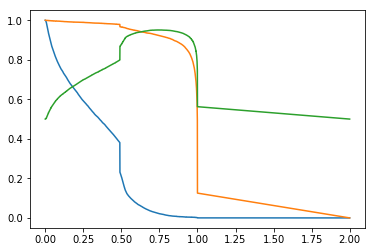

In [235]:
from matplotlib import pyplot as plt
%matplotlib inline
accuracies = 0.5 * (1.0 - fpr + tpr)
plt.plot(thresholds, fpr, thresholds, tpr, thresholds, accuracies)

In [203]:
np.max(accuracies)

0.95081905901712926

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline
precision = sklearn.metrics.precision_recall_curve(y_true, y_pred)[0]
recall = sklearn.metrics.precision_recall_curve(y_true, y_pred)[1]
f1_score = 2 * precision * recall / (precision + recall)

In [167]:
val_pr_tuple = sklearn.metrics.precision_recall_curve(
        val_y_true, val_y_pred)
    val_precisions = val_pr_tuple[0] * 100
    val_recalls = val_pr_tuple[1] * 100
    val_thresholds = val_pr_tuple[2]
    val_f1_scores =\
        2*val_precisions*val_recalls / (val_precisions+val_recalls)
    cv_best_threshold_id = np.argmax(val_f1_scores)
    cv_best_threshold = val_thresholds[cv_best_threshold_id]
    val_precision = val_precisions[cv_best_threshold_id]
    val_recall = val_recalls[cv_best_threshold_id]
    val_f1_score = val_f1_scores[cv_best_threshold_id]
    cv_val_y_pred = np.greater(val_y_pred, cv_best_threshold).astype('int')

    test_pred_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "clip-predictions.csv"])
    test_pred_path = os.path.join(trial_dir, test_pred_name)
    test_df = pd.read_csv(test_pred_path)

    test_y_true = list(val_df["Ground truth"])
    test_y_pred = list(val_df["Predicted probability"])

    test_pr_tuple = sklearn.metrics.precision_recall_curve(
        test_y_true, test_y_pred)
    test_precisions = test_pr_tuple[0] * 100
    test_recalls = test_pr_tuple[1] * 100
    test_thresholds = test_pr_tuple[2]
    test_f1_scores =\
        2*test_precisions*test_recalls / (test_precisions+test_recalls)
    oracle_best_threshold_id = np.argmax(test_f1_scores)
    oracle_best_threshold = test_thresholds[oracle_best_threshold_id]
    oracle_test_precision = test_precisions[oracle_best_threshold_id]
    oracle_test_recall = test_recalls[oracle_best_threshold_id]
    oracle_test_f1_score =\
            (2*oracle_test_precision*oracle_test_recall) /\
            (oracle_test_precision+oracle_test_recall)

    adhoc_test_y_pred = np.greater(test_y_pred, 0.5).astype('int')
    adhoc_test_precision = sklearn.metrics.precision_score(
        test_y_true, adhoc_test_y_pred) * 100
    adhoc_test_recall = sklearn.metrics.recall_score(
        test_y_true, adhoc_test_y_pred) * 100
    if adhoc_test_recall == 0.0 and adhoc_test_precision == 0.0:
        adhoc_test_f1_score = 0.0
    else:
        adhoc_test_f1_score =\
            (2*adhoc_test_precision*adhoc_test_recall) /\
            (adhoc_test_precision+adhoc_test_recall)
        
    cv_test_y_pred = np.greater(test_y_pred, cv_best_threshold).astype('int')
    cv_test_precision = sklearn.metrics.precision_score(
        test_y_true, cv_test_y_pred) * 100
    cv_test_recall = sklearn.metrics.recall_score(
        test_y_true, cv_test_y_pred) * 100
    cv_test_f1_score =\
        (2*cv_test_precision*cv_test_recall) /\
        (cv_test_precision+cv_test_recall)

'0.3333333333333333'